<a href="https://colab.research.google.com/github/anurag-singh2001/skin-cancer-detection-project/blob/master/ANN_vs_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
import os
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle

In [2]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 135 kB 35.6 MB/s 
     |████████████████████████████████| 1.6 MB 45.6 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Dataset

In [4]:
train_path = Path("/content/drive/My Drive/skin dataset/Train")
test_path = Path("/content/drive/My Drive/skin dataset/Test")

In [5]:
train_images = {}
for labels in train_path.iterdir():
    label = labels.name
    train_images[label] = []
    for img_p in labels.iterdir():
        train_images[label].append(img_p)

In [6]:
test_images = {}
for labels in test_path.iterdir():
    label = labels.name
    assert label not in test_images
    test_images[label] = []
    for img_p in labels.iterdir():
        test_images[label].append(img_p)

## Info of train dataset

In [7]:
print(f"{len(train_images)} classes in training set!")
print(f"{sum(len(cnt) for cnt in train_images.values())} images for training in total!")
print()
for label, imgs in train_images.items():
    print(f"{label}: {len(imgs)} images")

9 classes in training set!
2243 images for training in total!

vascular lesion: 139 images
pigmented benign keratosis: 462 images
squamous cell carcinoma: 181 images
dermatofibroma: 95 images
seborrheic keratosis: 77 images
nevus: 357 images
actinic keratosis: 114 images
melanoma: 442 images
basal cell carcinoma: 376 images


## Info of test dataset

In [8]:
print(f"{len(test_images)} classes in testing set!")
print(f"{sum(len(cnt) for cnt in test_images.values())} images for testing in total!")
print()
for label, imgs in test_images.items():
    print(f"{label}: {len(imgs)} images")

9 classes in testing set!
118 images for testing in total!

vascular lesion: 3 images
melanoma: 16 images
seborrheic keratosis: 3 images
actinic keratosis: 16 images
basal cell carcinoma: 16 images
squamous cell carcinoma: 16 images
dermatofibroma: 16 images
nevus: 16 images
pigmented benign keratosis: 16 images


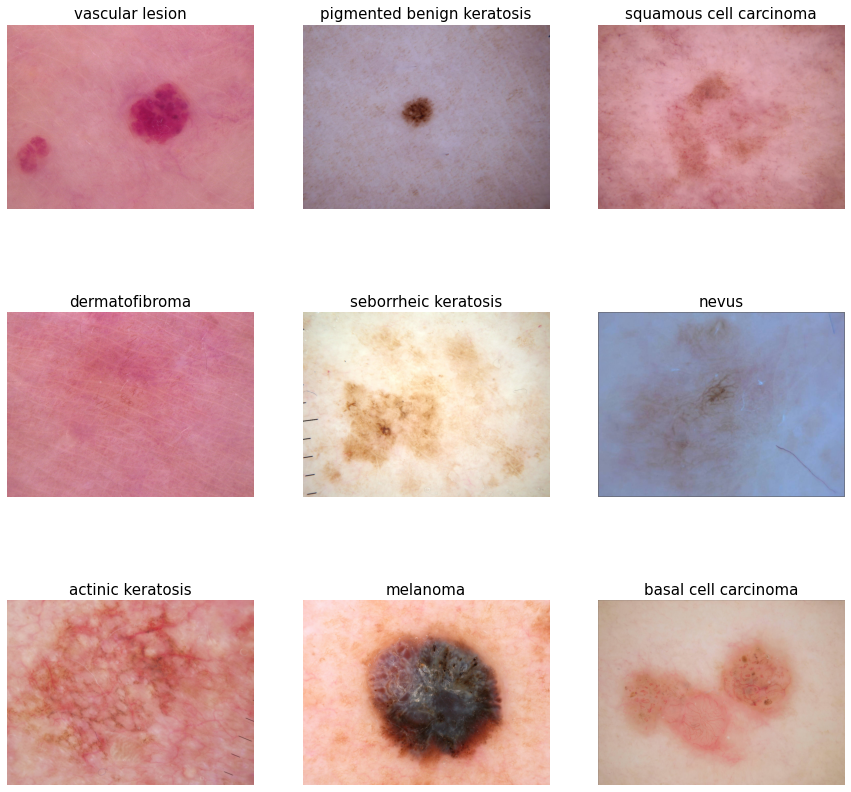

In [9]:
plt.figure(figsize=(15, 15))
for i, (label, imgs) in enumerate(train_images.items()):
    plt.subplot(3, 3, i + 1)
    plt.axis("off")
    plt.imshow(Image.open(imgs[0]))
    plt.title(label, fontsize=15)

In [57]:
Categories=['actinic keratosis','basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion']
target_arr=[]
x_train=[]
for i in Categories:
  print(f'loading... category : {i}')
  path=os.path.join(train_path,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(150,150,3))
    x_train.append(img_resized)
    target_arr.append(Categories.index(i))
  print(f'loaded category:{i} successfully')
x_train=np.array(x_train)
y_train=np.array(target_arr)

loading... category : actinic keratosis
loaded category:actinic keratosis successfully
loading... category : basal cell carcinoma
loaded category:basal cell carcinoma successfully
loading... category : dermatofibroma
loaded category:dermatofibroma successfully
loading... category : melanoma
loaded category:melanoma successfully
loading... category : nevus
loaded category:nevus successfully
loading... category : pigmented benign keratosis
loaded category:pigmented benign keratosis successfully
loading... category : seborrheic keratosis
loaded category:seborrheic keratosis successfully
loading... category : squamous cell carcinoma
loaded category:squamous cell carcinoma successfully
loading... category : vascular lesion
loaded category:vascular lesion successfully


In [58]:
Categories=['actinic keratosis','basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion']
target_arr=[]
x_test=[]
for i in Categories:
  print(f'loading... category : {i}')
  path=os.path.join(test_path,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(150,150,3))
    x_test.append(img_resized)
    target_arr.append(Categories.index(i))
  print(f'loaded category:{i} successfully')
x_test=np.array(x_test)
y_test=np.array(target_arr)

loading... category : actinic keratosis
loaded category:actinic keratosis successfully
loading... category : basal cell carcinoma
loaded category:basal cell carcinoma successfully
loading... category : dermatofibroma
loaded category:dermatofibroma successfully
loading... category : melanoma
loaded category:melanoma successfully
loading... category : nevus
loaded category:nevus successfully
loading... category : pigmented benign keratosis
loaded category:pigmented benign keratosis successfully
loading... category : seborrheic keratosis
loaded category:seborrheic keratosis successfully
loading... category : squamous cell carcinoma
loaded category:squamous cell carcinoma successfully
loading... category : vascular lesion
loaded category:vascular lesion successfully


## Normalizing the training data

In [60]:
x_train, x_test = x_train / 255.0, x_test / 255.0

print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)

shape of x_train:  (2243, 150, 150, 3)
shape of x_test:  (118, 150, 150, 3)


##Build the ANN Model

In [61]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(150, 150, 3)))
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(9,activation='softmax'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(
           learning_rate=hp_learning_rate),
                 loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
    return model

##Instantiate the tuner and perfrom hypertuning

In [62]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     executions_per_trial=3,
                     directory='project_files',
                     project_name='Skin cancer detection')

In [63]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [64]:
tuner.search(x_train, y_train,
             epochs=20,
             validation_data=(x_test, y_test),callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
 the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 25s]
val_accuracy: 0.1355932205915451

Best val_accuracy So Far: 0.1355932205915451
Total elapsed time: 00h 08m 13s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
 the optimal learning rate for the optimizer
is 0.01.



##Train the Model

In [65]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
57/57 [==============================] - 2s 18ms/step - loss: 1.7749 - accuracy: 0.2235 - val_loss: 7.1249 - val_accuracy: 0.0000e+00
Epoch 2/30
57/57 [==============================] - 1s 13ms/step - loss: 1.6777 - accuracy: 0.2352 - val_loss: 7.4158 - val_accuracy: 0.0000e+00
Epoch 3/30
57/57 [==============================] - 1s 13ms/step - loss: 1.6811 - accuracy: 0.2380 - val_loss: 6.3872 - val_accuracy: 0.1158
Epoch 4/30
57/57 [==============================] - 1s 13ms/step - loss: 1.6721 - accuracy: 0.2324 - val_loss: 6.2949 - val_accuracy: 0.0000e+00
Epoch 5/30
57/57 [==============================] - 1s 13ms/step - loss: 1.6708 - accuracy: 0.2291 - val_loss: 6.0542 - val_accuracy: 0.0000e+00
Epoch 6/30
57/57 [==============================] - 1s 13ms/step - loss: 1.6734 - accuracy: 0.2358 - val_loss: 7.0296 - val_accuracy: 0.0000e+00
Epoch 7/30
57/57 [==============================] - 1s 13ms/step - loss: 1.6714 - accuracy: 0.2297 - val_loss: 8.4651 - val_accuracy: 

##Evaluate the Trained Model

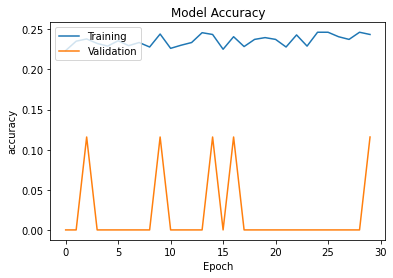

In [66]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [67]:
evaluation = model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", evaluation)

4/4 [==============================] - 0s 6ms/step - loss: 3.3798 - accuracy: 0.1356
[test loss, test accuracy]: [3.379835844039917, 0.1355932205915451]


In [68]:
y_pred=model.predict(x_test)
print("The predicted Data is :")
y_pred

4/4 [==============================] - 0s 5ms/step
The predicted Data is :


array([[6.8302184e-02, 2.0025273e-01, 5.8263592e-02, ..., 4.6305926e-05,
        7.0073394e-05, 4.8603779e-05],
       [6.8302184e-02, 2.0025273e-01, 5.8263592e-02, ..., 4.6305926e-05,
        7.0073394e-05, 4.8603779e-05],
       [6.8302184e-02, 2.0025273e-01, 5.8263592e-02, ..., 4.6305926e-05,
        7.0073394e-05, 4.8603779e-05],
       ...,
       [6.8302184e-02, 2.0025273e-01, 5.8263592e-02, ..., 4.6305926e-05,
        7.0073394e-05, 4.8603779e-05],
       [6.8302184e-02, 2.0025273e-01, 5.8263592e-02, ..., 4.6305926e-05,
        7.0073394e-05, 4.8603779e-05],
       [6.8302184e-02, 2.0025273e-01, 5.8263592e-02, ..., 4.6305926e-05,
        7.0073394e-05, 4.8603779e-05]], dtype=float32)

In [69]:
pickle.dump(model,open('ann_model.h5','wb'))
print("Pickle is dumped successfully")

Pickle is dumped successfully


1/1 [==============================] - 0s 109ms/step
The given image is of type = pigmented benign keratosis



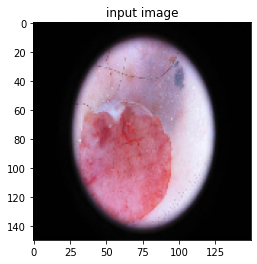

In [70]:
model=pickle.load(open('ann_model.h5','rb'))

path='/content/drive/My Drive/skin dataset/Test/melanoma/ISIC_0000004.jpg'
img=tf.keras.utils.load_img(path,target_size=(150,150,3))
img=tf.keras.utils.img_to_array(img)/255
img=np.array([img])
res = Categories[np.argmax(model.predict(img))]
print(f"The given image is of type = {res}")
print()
# to display the image  
plt.imshow(img[0], cmap = "gray")
plt.title("input image")
plt.show()